In [2]:
# SETTINGS
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))
display(HTML("<style>table {float:left}</style>"))
import warnings
warnings.filterwarnings('ignore')
import matplotlib
%matplotlib inline
%config Completer.use_jedi = False

<img src="images/ie-logo.png" width="250" height="250" align="right">

# AI - ML & Analytics

## Session 2: House Price Prediction

<img src="images/banner.png" width="800" height="800" align="center">

### Introduction:

This notebook will help us warm up / refresh our knowledge on Machine Learning and Analytics. You will need to have a working environment with the necessary libraries installed in order to do the task.

### Task: Practical example of ML for Real State investment prediction

In this exercise we provide you with a dataset [Ames Housing dataset](http://jse.amstat.org/v19n3/decock.pdf). You are required to do the following tasks:

**1)** The first thing you need to do is to upload the dataset. The dataset is located in the folder `/data/`.

**2)** Do a simple EDA to figure out what attributes you have, how good they are and what could be a first hint of good features.

**3)** Create a model.

### 1. Load the Ames dataset

Every ML approach starts with a defined Question. We need data to answer that question. With this data (if it happens to be good enough) we can apply a ML process and train an algorithm.

<img src="images/ML.png" width="800" height="800" align="center">

Load the dataset located in `data/dataset.csv` and have a quick view of it to get a grasp.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from pandas.api.types import is_object_dtype, is_bool_dtype
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error

In [4]:
raw_data = pd.read_csv('data/dataset.csv')
raw_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


The data contains a set of different **features** (numerical and categorical) and a target variable **SalePrice**. 

The goal of the ML process is, **using the provided data**, to be able to create a model for the **SalePrice** as a function of the **features**, that is:
    
$$
SalePrice = F (features)
$$

In [5]:
# have a look at the description of that dataset
! data/data_description.txt

/bin/bash: data/data_description.txt: Permission denied


### 2. Exploratory Data Analysis (EDA) or data pre-processing

The goal of EDA is to understand the data and see if we can answer our question with that data. 

EDA usually involves:

- Univariable study: learn about each feature with a focus on the dependent variable ('SalePrice').
- Multivariate study: understand how the dependent variable and independent variables relate.
- Basic cleaning: clean the dataset and handle missing data, outliers and categorical variables.
- Transform the variables if needed: test normality hypothesis etc.

In [6]:
report = ProfileReport(raw_data, minimal=True)
report

Summarize dataset:   0%|          | 0/89 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Following steps are being taken after consideration of the Pandas Profile Report and the text document explaining the data set.

In [7]:
# Drop useless features like ID or variables that have no variance
data = raw_data.drop(['Id','Street','Utilities','Heating','Condition2','LowQualFinSF','PoolQC','MiscVal','MoSold'], 1)

# Change years (i.e. 2001) to age (i.e. 20 years old)
data['Age'] = 2021 - data['YearBuilt']
data = data.drop('YearBuilt', 1)

data['AgeRemodAdd'] = 2021 - data['YearRemodAdd']
data = data.drop('YearRemodAdd', 1)

data['GarageAge'] = 2021 - data['GarageYrBlt']
data = data.drop('GarageYrBlt', 1)

# Does house have pool, fence, misc features, alley?
data['Pool'] = data['PoolArea'] > 0
data = data.drop('PoolArea', 1)
    
data['Fence'] = data['Fence'].notna()
    
data['MiscFeature'] = data['MiscFeature'].notna()
 
    #notna puts true if there is a value and false if theres a missing value
data['Alley'] = data['Alley'].notna()
    
# Does house have any of these features (yes/no) as they make no sense as numeric variables as there are too little that have each
for i in ['BsmtHalfBath','3SsnPorch','ScreenPorch','WoodDeckSF','OpenPorchSF','EnclosedPorch','MasVnrArea']:
    data[i] = data[i] > 0

# Converting data types
data['MSSubClass'] = data['MSSubClass'].astype('object')
data['YrSold'] = data['YrSold'].astype('object')

# Drop individual basement square feet measures as they form linear combination to make up total basement square feet
data = data.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'], 1)

# Drop individual living area square feet as combine to form GrLivArea and instead create new 
# variable of whether house has multiple stories or not
data['2floors'] = data['2ndFlrSF'] > 0
data = data.drop(['1stFlrSF','2ndFlrSF'],1)

# Turn booleans into object type
for name, col in data.items():
    if is_bool_dtype(col):
        data[name] = col.astype('object')

#### Remaining Missing Values

In [8]:
print('Missing Values')
data.isna().sum()[data.isna().sum()>0]

Missing Values


LotFrontage     259
MasVnrType        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
GarageAge        81
dtype: int64

In [9]:
# Fill missing garage age with 0
data['GarageAge'] = data['GarageAge'].fillna(value=0)

# Set missing values that just mean there is no basement, fireplace, or garage to 'None'
l = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond']
data[l] = data[l].fillna(value='None')

# Dropping any rows with missing values where the column has less than 20 missing values
data = data.dropna(subset=[col for col in data.columns if 0 < sum(data[col].isna()) < 20])

# Replacing LotFrontage NA by mean of column
data['LotFrontage'] = data['LotFrontage'].fillna((data['LotFrontage'].mean()))
# technically this should be done after train test split as the test set should not have any information included in the train set which it now does due 
# to calculating the mean on the entire data but for the purpose of this excercise it is done like this to save some time

In [10]:
data.isna().sum()[data.isna().sum()>0]

Series([], dtype: int64)

In [11]:
data2 = data.copy()

#### Multivariate Analysis

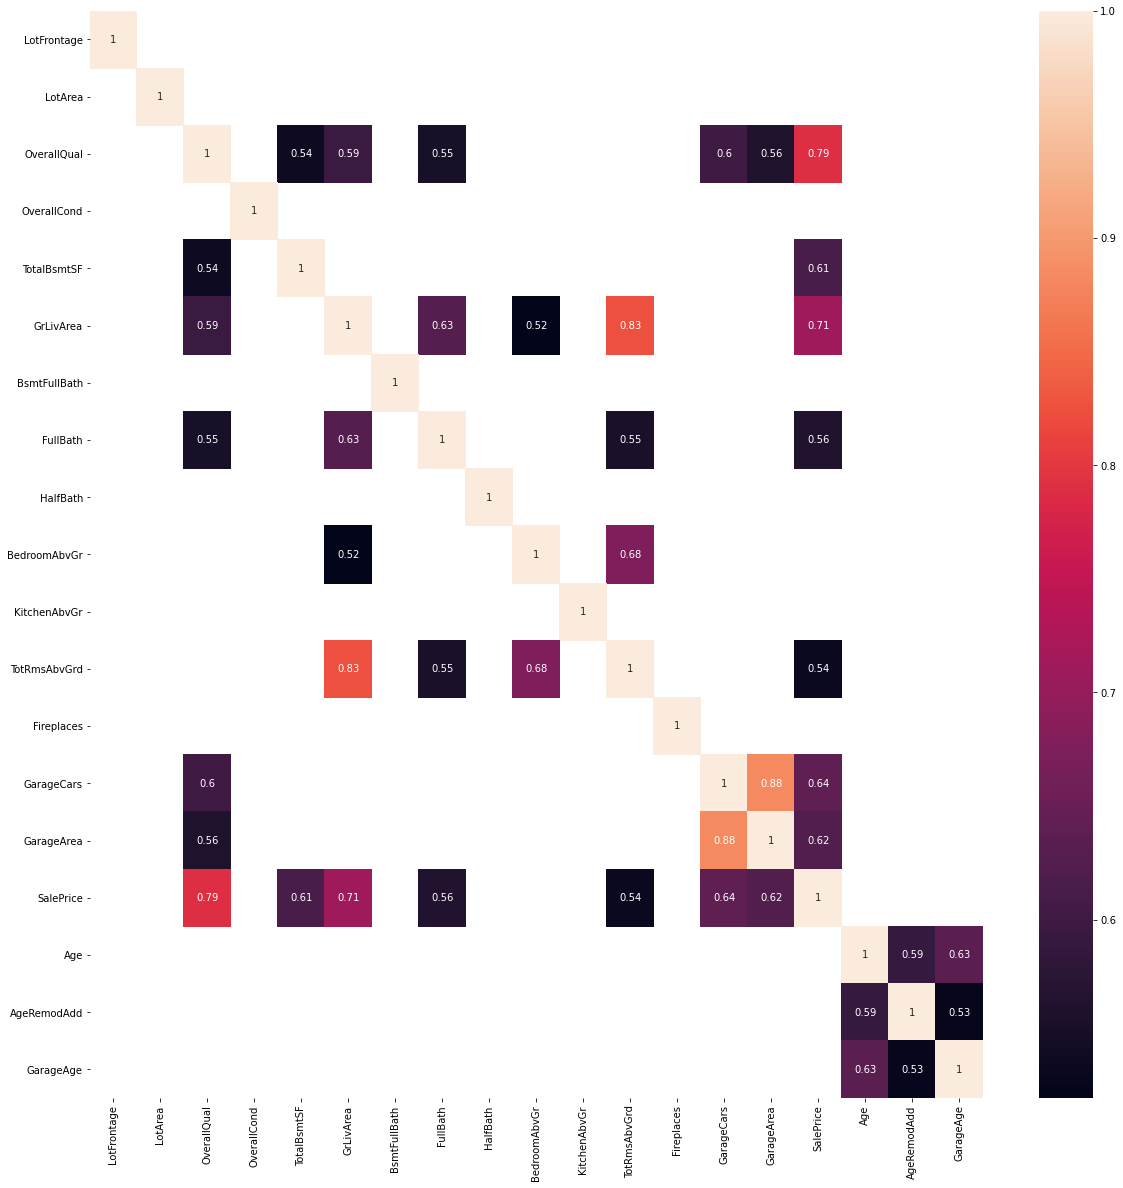

In [12]:
data_cor = data2.corr()[data2.corr()>0.5]

fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(data_cor, annot=True);

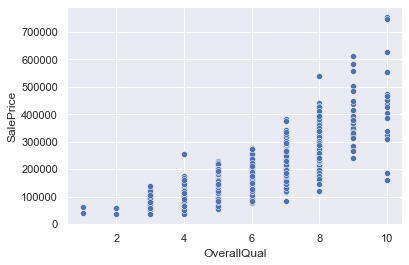

In [87]:
sns.set()
sns.scatterplot(data=data2, x='OverallQual', y='SalePrice');

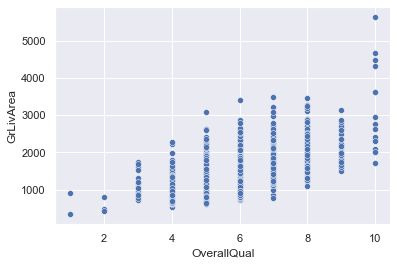

In [88]:
sns.set()
sns.scatterplot(data=data2, x='OverallQual', y='GrLivArea');

#### Dummifying

In [89]:
X = data2.drop('SalePrice', 1)
y = data2['SalePrice']

In [90]:
X_encoded = pd.get_dummies(X, columns=[col for col in X.columns if X[col].dtype == 'O'], drop_first=True)
X_encoded.head()

,LotFrontage,LotArea,OverallQual,OverallCond,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Pool_True,2floors_True
0,65.0,8450,7,5,856,1710,1,2,1,3,...,0,0,1,0,0,0,1,0,0,1
1,80.0,9600,6,8,1262,1262,0,2,0,3,...,0,0,1,0,0,0,1,0,0,0
2,68.0,11250,7,5,920,1786,1,2,1,3,...,0,0,1,0,0,0,1,0,0,1
3,60.0,9550,7,5,756,1717,1,1,0,3,...,0,0,1,0,0,0,0,0,0,1
4,84.0,14260,8,5,1145,2198,1,2,1,4,...,0,0,1,0,0,0,1,0,0,1


#### Train Test Split

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.30, random_state=18)

#### Outliers

In [95]:
lower_outlier_limit = np.mean(y_train) - (2 * np.std(y_train))
upper_outlier_limit = np.mean(y_train) + (2 * np.std(y_train))

def less_outliers(data, X, lower_limit, upper_limit):
    data_no_out = data[(data>lower_limit)&(data<upper_limit)]
    X_no_out = X[(data>lower_limit)&(data<upper_limit)]
    print(len(data)-len(data_no_out),'houses with prices lower than',round(lower_limit),'and higher than',round(upper_limit),'dollars are removed.')
    return data_no_out, X_no_out

y_train2, X_train2 = less_outliers(y_train, X_train, lower_outlier_limit, upper_outlier_limit)
y_test2, X_test2 = less_outliers(y_test, X_test, lower_outlier_limit, upper_outlier_limit)

43 houses with prices lower than 18972 and higher than 340783 dollars are removed.
17 houses with prices lower than 18972 and higher than 340783 dollars are removed.


#### Transformation

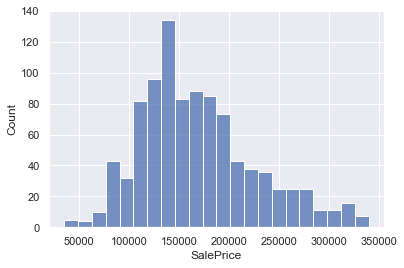

In [97]:
sns.histplot(data=y_train2);

Sales price is definitely not normally distributed as it is right skewed but by using TransformedTargetRegressor later the target variable is automatically transformed.

**Based on those insights, what do you think we can do to predict house prices?**

**Can you think of a model to do it?**

This is a Regression problem. We can use many algorithms from Multivariate Linear Regression through Elastic Nets, Random Forest etc. For the purpose of this excercise so that there are not too many parameters to tune and it's not the simplest model either I chose Elastic Nets.

## Train a model on the data

In [100]:
elastic_params = np.arange(0.001, 1, 0.001)
l1_ratio = np.arange(0.1, 1,0.1).astype(float)

elastic = TransformedTargetRegressor(regressor=ElasticNetCV(alphas = elastic_params, l1_ratio=l1_ratio, cv = KFold(5)), transformer = QuantileTransformer(output_distribution='normal'))
elastic_fit = elastic.fit(X_train2, y_train2)
y_train_pred = elastic_fit.predict(X_train2)
y_pred = elastic_fit.predict(X_test2)
print("Train RMSLE:", np.sqrt(mean_squared_error(y_train2, y_train_pred)),
      "\nTest RMSLE:", np.sqrt(mean_squared_error(y_test2, y_pred)))
print("\nBest alpha:", elastic_fit.regressor_.alpha_)
print("\nBest L1 Ratio:", elastic_fit.regressor_.l1_ratio_)

Train RMSLE: 18330.748392310863 
Test RMSLE: 20986.368074327784

Best alpha: 0.013000000000000001

Best L1 Ratio: 0.1


**Based on those results, what do you think about the model? Is it a good model or a bad model?**

**What would be the next step?**

The model is okay but slightly overfitting and is off by around 20k on average in predicted Sale Price. It could definitely still be improved.

Check if model meets assumptions such as heteroscasticity, or if the residual plots reveal anything about non-linear relationships etc.
More importantly, however, many different models should be evaluated in a competitive way to see which performs best on the data. Also, feature selection like recursive feature elimination should be performed. Also more feature engineering could be done to extract more meaningful variables.